In [1]:
import numpy as np
from numpy import ma
from netCDF4 import num2date

import xarray as xr
import pandas as pd
from scipy.stats import pearsonr
from scipy.interpolate import interp2d

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.dates as mdates

from pycurrents.num import interp1

import sys

In [2]:
# Directories
voldir = '/Volumes/SamT5/PhD/data/'
griddir = voldir + 'altimetry_cpom/3_grid_dot/'
mdir = voldir + 'moorings/SWE_Dotson/'
topodir = voldir + 'topog/'

localdir = '/Users/ocd1n16/PhD_local/'
figdir = localdir + 'data_figures/Figures_jan23/'

auxscriptdir = localdir + 'scripts/aux_func/'
sys.path.append(auxscriptdir)
import aux_func_trend as fc

In [3]:
savefig = True

In [5]:
# S1 mooring data
s1_start = '2010-03-01'
s1_end = '2015-12-31'

mfile = 's1_raw_uv_hourly_adcp_404m_540m_2010_2016.nc'
dep_min_max = [412, 536]

with xr.open_dataset(mdir + mfile) as s1moor:
    print(s1moor.keys())

s1 = s1moor.sel(depth=slice(dep_min_max[0], dep_min_max[1]))

# average data daily
s1d = s1.resample(time="1D").mean()

s1d_filt = s1d.rolling(time=15, min_periods=1, center=True).mean()

tim, dep = s1d.u.shape
rot_u, rot_v = [np.ones((tim, dep)) for _ in range(2)]

for i in range(dep):
    rot_vel = fc.rotate_frame(s1d_filt.u[:, i], s1d_filt.v[:, i], 42, 'clockwise')
    rot_u[:, i] = rot_vel.u.values
    rot_v[:, i] = rot_vel.v.values

# add new components to existing dataset
s1d_filt["rot_u"] = (("time", 'depth'), rot_u)
s1d_filt["rot_v"] = (("time", "depth"), rot_v)


KeysView(<xarray.Dataset>
Dimensions:  (depth: 18, time: 51839)
Coordinates:
  * time     (time) datetime64[ns] 2010-02-15T15:00:00 ... 2016-01-17T03:00:00
  * depth    (depth) float64 404.0 412.0 420.0 428.0 ... 516.0 524.0 532.0 540.0
Data variables:
    u        (time, depth) float64 ...
    v        (time, depth) float64 ...
Attributes:
    lon:      -116.358
    lat:      -72.468)


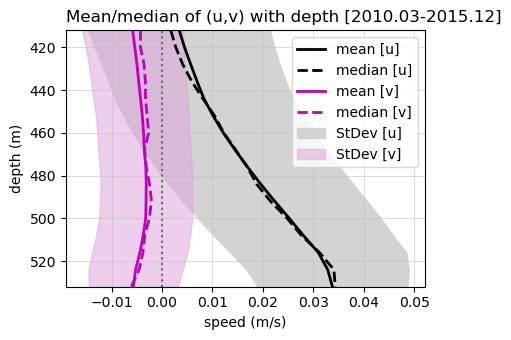

In [6]:
var = s1d_filt.resample(time='1MS').mean().sel(time=slice(s1_start, s1_end))

var_anom = var - var.mean("time")

#-----------------------------------
# date axis for plots later on
ms1_date = var.time.dt.strftime("%m/%Y").values
ndays = mdates.date2num(list(var.time.values)) 
dt = ndays - ndays[0] # for computing linear trend

xtim = pd.to_datetime(var.time.values)
ydepth = var.depth.values
depth_dim = len(ydepth)

#-----------------------------------
# time-mean of u, v with depth
#-----------------------------------
# integer number of years
ms1_mean = var.mean("time")
ms1_median = var.median("time")

# standard deviation envelope
neg_std = ms1_mean - var.std("time", ddof=1)
pos_std = ms1_mean + var.std("time", ddof=1)

# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
# >  >  >  > mean/median with depth and stdev
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
fig, ax = plt.subplots(figsize=(4.5, 3.5), dpi=100)
ax.plot(ms1_mean.rot_u.values, ydepth, ls='-', lw=2, 
  c='k', label='mean [u]')
ax.plot(ms1_median.rot_u.values, ydepth, ls='--', lw=2, 
  c='k', label='median [u]')

# StDev envelope for rot_uf rel to the Jan2011/Dec2015 time mean
ax.fill_betweenx(ydepth, neg_std.rot_u.values, pos_std.rot_u.values,
  color='lightgrey', label='StDev [u]')

ax.plot(ms1_mean.rot_v.values, ydepth, ls='-', lw=2, 
  c='m', label='mean [v]')
ax.plot(ms1_median.rot_v.values, ydepth, ls='--', lw=2, 
  c='m', label='median [v]')
ax.fill_betweenx(ydepth, neg_std.rot_v.values, pos_std.rot_v.values, 
  color='plum', alpha=0.5, label='StDev [v]')

ax.grid(True, c='silver', lw=.4, zorder=1)
ax.axvline(0, c='dimgrey', ls=':')
ax.set_xlabel("speed (m/s)")
ax.set_ylabel("depth (m)")
ax.invert_yaxis()
ax.set_ylim(ydepth[-1], ydepth[0])
ax.legend()
ax.set_title('Mean/median of (u,v) with depth [2010.03-2015.12]', loc='left')
plt.tight_layout()
if savefig:
    fig.savefig(figdir + 's1_depth_profile_mean.png')

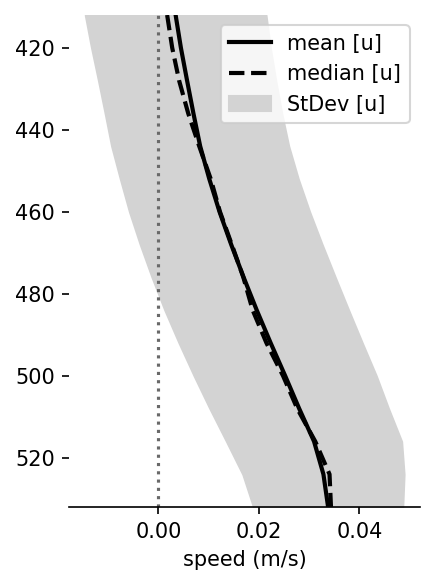

In [7]:
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
# >  >  >  > mean/median with depth and stdev
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
fig, ax = plt.subplots(figsize=(3, 4), dpi=150)
ax.plot(ms1_mean.rot_u.values, ydepth, ls='-', lw=2, 
  c='k', label='mean [u]')
ax.plot(ms1_median.rot_u.values, ydepth, ls='--', lw=2, 
  c='k', label='median [u]')

# StDev envelope for rot_uf rel to the Jan2011/Dec2015 time mean
ax.fill_betweenx(ydepth, neg_std.rot_u.values, pos_std.rot_u.values,
  color='lightgrey', label='StDev [u]')

#ax.grid(True, c='silver', lw=.4, zorder=1)
ax.axvline(0, c='dimgrey', ls=':')
ax.set_xlabel("speed (m/s)")
#ax.set_ylabel("depth (m)")
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.invert_yaxis()
ax.set_ylim(ydepth[-1], ydepth[0])
ax.legend()
#ax.set_title('Mean/median of u with depth [2010.03-2015.12]', loc='left')
plt.tight_layout()
if savefig:
    fig.savefig(figdir + 's1_depth_profile_mean_rot_u.png')

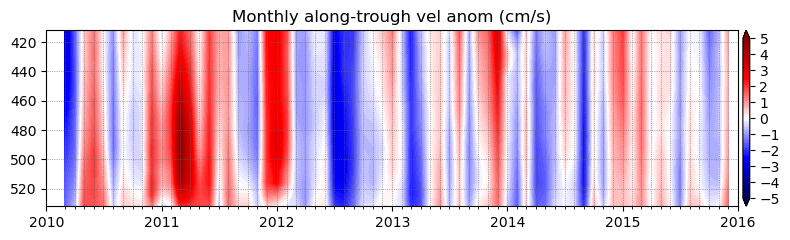

In [8]:
xg, yg = np.meshgrid(xtim, var.depth)
levels=np.linspace(-5, 5, 100)

# > u
plt.ion()
fig, ax = plt.subplots(figsize=(8, 2.5), dpi=100)
cs = ax.contourf(xg, yg, var_anom.u.T*100, 
                 cmap=cm.seismic, 
                 levels=levels,
                 extend='both')
ax.invert_yaxis()
ax.set_title("Monthly along-trough vel anom (cm/s)")

# month ticks
ax.set_xticks(xtim, minor=True)
ax.grid(True, which='minor', c='dimgrey',ls=':', lw=.5)
ax.grid(True, which='major', c='dimgrey',ls=':', lw=.5)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.05)
cticks = np.linspace(-5, 5, 11) 
plt.colorbar(cs, cax=cax, ticks=cticks)
ax.set_xlim(pd.to_datetime('2010-01-01'), 
  pd.to_datetime('2016-01-01'))
plt.tight_layout()
if savefig:
    fig.savefig(figdir + 's1_depth_profile.png')

In [9]:
# compute depth average
mts1 = var_anom.mean("depth")

In [10]:
#---------------------------------------------------------------------
# B. depth average then remove linear trend [stick to this frm now on]
#---------------------------------------------------------------------
a, u_det = fc.trend_ci(mts1.rot_u, 0.95)

print(mts1.time.values[0], mts1.time.values[-1])
print('> > rot_u')
print('trend (cm/yr): ', a.slope.values*36500)
print('CI (95%): ', a.ci.values*36500)

2010-03-01T00:00:00.000000000 2015-12-01T00:00:00.000000000
> > rot_u
trend (cm/yr):  -0.20781685196753008
CI (95%):  0.2380280123236284


In [11]:
# 1. time mean of entire dataset (multiyear anomalies)
# compare Stdev with depth to StDev with time

# standard deviation with depth (measure of how barotropic is the flow?)
# standard deviation with time 
# > > u
u_anom_std_depth = var_anom.rot_u.std("depth", ddof=1)
u_anom_std_time = u_det.std(ddof=1)
u_anom_stand = u_det / u_anom_std_time

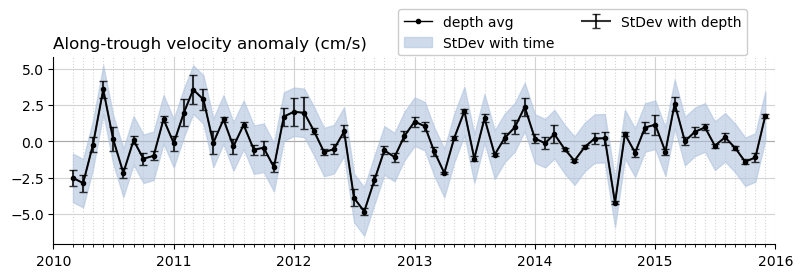

In [12]:
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
# u time series + StDevs
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
xtim = pd.to_datetime(u_det.time.values)
fig, ax = plt.subplots(figsize=(8, 3), dpi=100)
ax.plot(xtim, u_det*1e2,
  c='k', marker='o', markersize=3, lw=1, zorder=6, label='depth avg')
ax.errorbar(xtim, u_det*1e2,
  u_anom_std_depth*1e2, color='k', capsize=3,
  alpha=0.8, zorder=6, label='StDev with depth')
ax.fill_between(xtim, (u_det-u_anom_std_time)*1e2,
  (u_det+u_anom_std_time)*1e2, color='lightsteelblue',
  alpha=0.6, zorder=3, label='StDev with time')

ax.set_title("Along-trough velocity anomaly (cm/s)", loc='left')

ax.axhline(0, c='darkgrey', lw=.8, zorder=2)
ax.set_xticks(xtim, minor=True)
ax.grid(True, which="minor", ls=':', 
      c='lightgrey', zorder=1)
ax.grid(True, which="major", 
      c='lightgrey', zorder=1)
ax.set_xlim(pd.to_datetime('2010-01-01'), 
  pd.to_datetime('2016-01-01'))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(ncol=2, bbox_to_anchor=(.17,1.19,.8,.1), framealpha=1)
plt.tight_layout()
if savefig:
    fig.savefig(figdir + 's1_timeseries.png')

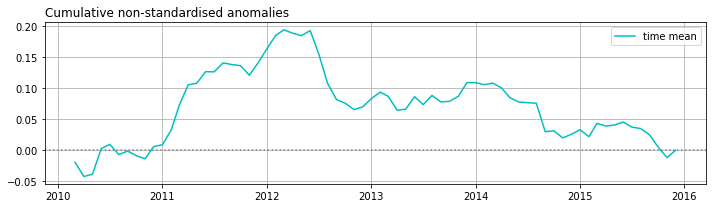

In [13]:
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
# cumulative time series
# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
ts1_anom_cumulative = mts1.rot_u.cumsum()

plt.ion()
fig, ax = plt.subplots(figsize=(10,3))
ax.plot(xtim, ts1_anom_cumulative.values, c='c', label='time mean')
ax.legend()
ax.set_title("Cumulative non-standardised anomalies", loc='left')
ax.axhline(0, c='grey', ls=':')
ax.grid(True)
plt.tight_layout()